In [5]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from survshares.datasets import Rossi, Metabric, GBSG2
from sklearn.model_selection import train_test_split
# Prepare dataset
dataset = Metabric()
X, T, E = dataset.load(normalise=False)
X_train, X_test, T_train, T_test, E_train, E_test = train_test_split(
    X, T, E, test_size=0.2, random_state=42
)

In [7]:
from survshares.metrics import negative_pll 
from gplearn.gplearn.fitness import make_fitness

def fitness_npll_shrink(y_true, y_pred, sample_weight):
    """
    Partial log-likelihood with shrink penalty for gplearn. Smaller is better.
    """
    pll = negative_pll(y_true, y_pred, sample_weight)
    result = pll + 0.05 * np.abs(y_pred).mean()
    if np.isinf(result):
        result = np.inf # Cover -inf with +inf
    return result


fitness_npll_shrink = make_fitness(
    function=fitness_npll_shrink, greater_is_better=False
)

In [8]:
from gplearn.gplearn.model import ShapeNN
from gplearn.gplearn.genetic import SymbolicRegressor

def init_share_regressor(metric, device, checkpoint_dir, categorical_variables={}):
    gp_config = {
        "population_size": 5,
        "generations": 5,
        "tournament_size": 10,
        "function_set": ("add", "mul", "div", "shape"),
        "verbose": True,
        "random_state": 42,
        "const_range": None,
        "n_jobs": 1,
        "p_crossover": 0.4,
        "p_subtree_mutation": 0.2,
        "p_point_mutation": 0.2,
        "p_hoist_mutation": 0.05,
        "p_point_replace": 0.2,
        "parsimony_coefficient": 0.0,
        "metric": metric,
        "parsimony_coefficient": 0.0,
        "optim_dict": {
            "alg": "adam",
            "lr": 1e-2,  # tuned automatically
            "max_n_epochs": 100,
            "tol": 1e-3,
            "task": "survival",
            "device": device,
            "batch_size": 1000,
            "shape_class": ShapeNN,
            "constructor_dict": {
                "n_hidden_layers": 5,
                "width": 10,
                "activation_name": "ELU",
            },
            "num_workers_dataloader": 0,
            "seed": 42,
            "checkpoint_folder": checkpoint_dir,
            "keep_models": True,
        },
    }

    return SymbolicRegressor(**gp_config, categorical_variables=categorical_variables)


model = init_share_regressor(
    metric = fitness_npll_shrink, 
    device = "cpu",
    checkpoint_dir = Path("data/checkpoints/survshare_rossi"),
    #categorical_variables = dataset.categorical_dict
)

model.fit(torch.Tensor(X), torch.Tensor(T), torch.Tensor(E))

/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
None -> None -> add(shape(div(add(X8, mul(X0, X7)), mul(X6, shape(X5)))), shape(X3))
add(shape(div(add(X8, mul(X0, X7)), mul(X6, shape(X5)))), shape(X3))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 0.005754399373371567
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_43670a91-dacd-4f8b-98bc-c05e22b12366.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_43670a91-dacd-4f8b-98bc-c05e22b12366.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
/home/paperspace/SurvSHAREs/gplearn/gplearn/_program.py:1073: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictionary = pd.concat([dictionary,new_row],ignore_index=True)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


add(shape(div(add(X8, mul(X0, X7)), mul(X6, shape(X5)))), shape(X3))
add(shape(div(add(X8, mul(X0, X7)), mul(X6, shape(X5)))), shape(X3)) | raw_fitness: 5.295464992523193
1
Min error so far: 5.295464992523193
None -> None -> mul(mul(div(shape(X1), X4), div(X6, X2)), shape(mul(X5, X0)))
mul(mul(div(shape(X1), X4), div(X6, X2)), shape(mul(X5, X0)))


/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/paperspace/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-20T16.36.05 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.3311311214825908
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_7b7ee797-6382-4dec-9ab0-a21a55a1db68.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_7b7ee797-6382-4dec-9ab0-a21a55a1db68.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


mul(mul(div(shape(X1), X4), div(X6, X2)), shape(mul(X5, X0)))
mul(mul(div(shape(X1), X4), div(X6, X2)), shape(mul(X5, X0))) | raw_fitness: 5.313814640045166
2
Min error so far: 5.295464992523193
None -> None -> add(add(X3, shape(X6)), div(add(X7, shape(X2)), mul(X0, mul(mul(X8, div(shape(X5), shape(X4))), shape(X1)))))
add(add(X3, shape(X6)), div(add(X7, shape(X2)), mul(X0, mul(mul(X8, div(shape(X5), shape(X4))), shape(X1)))))


/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/paperspace/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-20T16.36.05 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 92 steps due to diverging loss.
Learning rate set to 0.005754399373371567
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_6f849dc9-b26e-4e42-9bc0-86bbe8d873bf.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_6f849dc9-b26e-4e42-9bc0-86bbe8d873bf.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


add(add(X3, shape(X6)), div(add(X7, shape(X2)), mul(X0, mul(mul(X8, div(shape(X5), shape(X4))), shape(X1)))))
add(add(X3, shape(X6)), div(add(X7, shape(X2)), mul(X0, mul(mul(X8, div(shape(X5), shape(X4))), shape(X1))))) | raw_fitness: 5.653522968292236
3
Min error so far: 5.295464992523193
None -> None -> div(shape(div(add(mul(X4, X6), X3), add(shape(X5), X1))), shape(X0))
div(shape(div(add(mul(X4, X6), X3), add(shape(X5), X1))), shape(X0))


/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/paperspace/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-20T16.36.05 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0002089296130854041
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_a7230f01-4a3b-4296-9607-cb2ab6df8ba8.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_a7230f01-4a3b-4296-9607-cb2ab6df8ba8.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


div(shape(div(add(mul(X4, X6), X3), add(shape(X5), X1))), shape(X0))
div(shape(div(add(mul(X4, X6), X3), add(shape(X5), X1))), shape(X0)) | raw_fitness: 5.372244358062744
4
Min error so far: 5.295464992523193
None -> None -> shape(div(shape(mul(mul(shape(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))
shape(div(shape(mul(mul(shape(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))


/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/paperspace/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-20T16.36.05 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 0.01
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_54b0a82e-4896-44b6-a93c-6ba2f47d4aae.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_54b0a82e-4896-44b6-a93c-6ba2f47d4aae.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


shape(div(shape(mul(mul(shape(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))
shape(div(shape(mul(mul(shape(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5))) | raw_fitness: 5.25784158706665
5
Min error so far: 5.25784158706665
Best program: shape(div(shape(mul(mul(shape(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))
   0    18.60          5.37858       30          5.25784              N/A      5.13m
mul(mul(div(shape(X1), X4), div(X6, X2)), shape(mul(X5, X0))) -> Point Mutation -> add(mul(div(shape(X1), X4), div(X6, X2)), shape(mul(X5, X0)))
add(mul(div(shape(X1), X4), div(X6, X2)), shape(mul(X5, X0)))


/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/paperspace/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-20T16.36.05 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.005754399373371567
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_978d7c75-d4e7-4f77-b46e-5603628585b7.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_978d7c75-d4e7-4f77-b46e-5603628585b7.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


add(mul(div(shape(X1), X4), div(X6, X2)), shape(mul(X5, X0)))
add(mul(div(shape(X1), X4), div(X6, X2)), shape(mul(X5, X0))) | raw_fitness: 5.310760021209717
6
Min error so far: 5.25784158706665
shape(div(shape(mul(mul(shape(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5))) -> Point Mutation -> shape(div(shape(mul(mul(shape(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))
Retrieved score for shape(div(shape(mul(mul(shape(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))
shape(div(shape(mul(mul(shape(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5))) -> Hoist Mutation -> shape(div(shape(mul(mul(shape(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), s

/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/paperspace/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-20T16.36.05 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.47863009232263803
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_6b1d2635-9f88-4673-b0ed-91c2f6716da3.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_6b1d2635-9f88-4673-b0ed-91c2f6716da3.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


shape(div(shape(mul(mul(shape(mul(add(div(mul(X6, add(shape(X3), shape(X7))), X4), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))
shape(div(shape(mul(mul(shape(mul(add(div(mul(X6, add(shape(X3), shape(X7))), X4), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5))) | raw_fitness: inf
7
Min error so far: 5.25784158706665
shape(div(shape(mul(mul(shape(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5))) -> Reproduction -> shape(div(shape(mul(mul(shape(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))
Retrieved score for shape(div(shape(mul(mul(shape(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))
Best program: shape(div(shape(mul(mul(shape(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))),

/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/paperspace/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-20T16.36.05 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 0.6918309709189363
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_0aab9a93-a1e0-496e-8c5d-e1348f9f862e.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_0aab9a93-a1e0-496e-8c5d-e1348f9f862e.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


shape(mul(mul(div(div(add(div(shape(X3), shape(X0)), shape(X1)), shape(X6)), shape(X2)), shape(X4)), shape(X8)))
shape(mul(mul(div(div(add(div(shape(X3), shape(X0)), shape(X1)), shape(X6)), shape(X2)), shape(X4)), shape(X8))) | raw_fitness: inf
8
Min error so far: 5.25784158706665
shape(div(shape(mul(mul(shape(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5))) -> Subtree Mutation -> shape(div(shape(mul(mul(shape(mul(add(shape(div(div(add(shape(X3), shape(X7)), shape(X4)), shape(X6))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))
shape(div(shape(mul(mul(shape(mul(add(shape(div(div(add(shape(X3), shape(X7)), shape(X4)), shape(X6))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))


/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/paperspace/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-20T16.36.05 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 0.6918309709189363
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_88a82b10-edf4-4ad3-ad32-9439ff9a1189.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_88a82b10-edf4-4ad3-ad32-9439ff9a1189.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


shape(div(shape(mul(mul(shape(mul(add(shape(div(div(add(shape(X3), shape(X7)), shape(X4)), shape(X6))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))
shape(div(shape(mul(mul(shape(mul(add(shape(div(div(add(shape(X3), shape(X7)), shape(X4)), shape(X6))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5))) | raw_fitness: inf
9
Min error so far: 5.25784158706665
shape(div(shape(mul(mul(shape(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5))) -> Point Mutation -> shape(div(shape(mul(mul(shape(add(add(shape(add(add(add(shape(X7), shape(X1)), shape(X3)), shape(X4))), shape(X6)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))
shape(div(shape(mul(mul(shape(add(add(shape(add(add(add(shape(X7), shape(X1)), shape(X3)), shape(X4))), shape(X6)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))


/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/paperspace/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-20T16.36.05 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_4ba7f307-6e15-4a39-89b8-36880bf3f512.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_4ba7f307-6e15-4a39-89b8-36880bf3f512.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


shape(div(shape(mul(mul(shape(add(add(shape(add(add(add(shape(X7), shape(X1)), shape(X3)), shape(X4))), shape(X6)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))
shape(div(shape(mul(mul(shape(add(add(shape(add(add(add(shape(X7), shape(X1)), shape(X3)), shape(X4))), shape(X6)), shape(X8))), shape(X0)), shape(X2))), shape(X5))) | raw_fitness: 5.326303482055664
10
Min error so far: 5.25784158706665
shape(div(shape(mul(mul(shape(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5))) -> Crossover -> shape(div(shape(mul(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8)), shape(X2))), shape(X5)))
shape(div(shape(mul(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8)), shape(X2))), shape(X5)))


/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/paperspace/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-20T16.36.05 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.15848931924611143
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_00a36f3b-22d7-4cc9-b873-c45da1459617.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_00a36f3b-22d7-4cc9-b873-c45da1459617.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


shape(div(shape(mul(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8)), shape(X2))), shape(X5)))
shape(div(shape(mul(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8)), shape(X2))), shape(X5))) | raw_fitness: 6.6743645668029785
11
Min error so far: 5.25784158706665
shape(div(shape(mul(mul(shape(mul(add(shape(mul(mul(add(shape(X7), shape(X6)), shape(X3)), shape(X4))), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5))) -> Crossover -> shape(div(shape(mul(mul(shape(mul(add(add(shape(X7), shape(X6)), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))
shape(div(shape(mul(mul(shape(mul(add(add(shape(X7), shape(X6)), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))


/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/paperspace/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-20T16.36.05 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.036307805477010104
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_83bad102-476c-48a2-a94e-79705efecda5.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_83bad102-476c-48a2-a94e-79705efecda5.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


shape(div(shape(mul(mul(shape(mul(add(add(shape(X7), shape(X6)), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))
shape(div(shape(mul(mul(shape(mul(add(add(shape(X7), shape(X6)), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5))) | raw_fitness: 5.263436317443848
12
Min error so far: 5.25784158706665
Best program: shape(div(shape(mul(mul(shape(mul(add(add(shape(X7), shape(X6)), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))
   3    26.00              inf       23          5.26344              N/A      1.39m
shape(div(shape(mul(mul(shape(mul(add(add(shape(X7), shape(X6)), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5))) -> Crossover -> shape(X6)
shape(X6)


/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/paperspace/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-20T16.36.05 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.47863009232263803
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_59b89a64-e066-4565-9b8d-5561b5c9fd52.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_59b89a64-e066-4565-9b8d-5561b5c9fd52.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/paperspace/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-20T16.36.05 exists and is not empty.


shape(X6)
shape(X6) | raw_fitness: 5.3594160079956055
13
Min error so far: 5.25784158706665
shape(div(shape(mul(mul(shape(mul(add(add(shape(X7), shape(X6)), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5))) -> Subtree Mutation -> shape(div(shape(mul(mul(shape(div(shape(X3), shape(X4))), shape(X0)), shape(X2))), shape(X5)))
shape(div(shape(mul(mul(shape(div(shape(X3), shape(X4))), shape(X0)), shape(X2))), shape(X5)))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 0.6918309709189363
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_c7199cab-1e03-4d74-8374-d6b1a74f5fd8.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_c7199cab-1e03-4d74-8374-d6b1a74f5fd8.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


shape(div(shape(mul(mul(shape(div(shape(X3), shape(X4))), shape(X0)), shape(X2))), shape(X5)))
shape(div(shape(mul(mul(shape(div(shape(X3), shape(X4))), shape(X0)), shape(X2))), shape(X5))) | raw_fitness: inf
14
Min error so far: 5.25784158706665
shape(div(shape(mul(mul(shape(add(add(shape(add(add(add(shape(X7), shape(X1)), shape(X3)), shape(X4))), shape(X6)), shape(X8))), shape(X0)), shape(X2))), shape(X5))) -> Crossover -> shape(div(shape(mul(shape(X7), shape(X2))), shape(X5)))
shape(div(shape(mul(shape(X7), shape(X2))), shape(X5)))


/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/paperspace/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-20T16.36.05 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Learning rate set to 0.6918309709189363
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_ca43d5e8-c79b-4184-bdd3-ece3a3f895f7.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_ca43d5e8-c79b-4184-bdd3-ece3a3f895f7.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


shape(div(shape(mul(shape(X7), shape(X2))), shape(X5)))
shape(div(shape(mul(shape(X7), shape(X2))), shape(X5))) | raw_fitness: 8.673163414001465
15
Min error so far: 5.25784158706665
shape(div(shape(mul(mul(shape(mul(add(add(shape(X7), shape(X6)), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5))) -> Point Mutation -> shape(div(shape(mul(mul(shape(mul(add(add(shape(X3), shape(X4)), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))
shape(div(shape(mul(mul(shape(mul(add(add(shape(X3), shape(X4)), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))


/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/paperspace/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-20T16.36.05 exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.01
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_2cc7a49f-feb1-4456-b9d0-a6ba64a092d6.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_2cc7a49f-feb1-4456-b9d0-a6ba64a092d6.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.


shape(div(shape(mul(mul(shape(mul(add(add(shape(X3), shape(X4)), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))
shape(div(shape(mul(mul(shape(mul(add(add(shape(X3), shape(X4)), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5))) | raw_fitness: 5.2499518394470215
16
Min error so far: 5.2499518394470215
shape(div(shape(mul(mul(shape(mul(add(add(shape(X7), shape(X6)), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5))) -> Reproduction -> shape(div(shape(mul(mul(shape(mul(add(add(shape(X7), shape(X6)), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))
Retrieved score for shape(div(shape(mul(mul(shape(mul(add(add(shape(X7), shape(X6)), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))
Best program: shape(div(shape(mul(mul(shape(mul(add(add(shape(X3), shape(X4)), shape(X1)), shape(X8))), shape(X0)), shape(X2))), shape(X5)))
   4    15.00              inf       23          5.24995              N/A      0.00s


SymbolicRegressor(categorical_variables={}, const_range=None,
                  function_set=('add', 'mul', 'div', 'shape'), generations=5,
                  metric=<gplearn.gplearn.fitness._Fitness object at 0x7fe6518de710>,
                  optim_dict={'alg': 'adam', 'batch_size': 1000,
                              'checkpoint_folder': PosixPath('data/checkpoints/survshare_rossi'),
                              'constructor_dict': {'activation_name': 'ELU',
                                                   'n_hidden_layers':...
                              'device': 'cpu', 'keep_models': True, 'lr': 0.01,
                              'max_n_epochs': 100, 'num_workers_dataloader': 0,
                              'seed': 42,
                              'shape_class': <class 'gplearn.gplearn.model.ShapeNN'>,
                              'task': 'survival', 'tol': 0.001},
                  p_crossover=0.4, p_hoist_mutation=0.05, p_point_mutation=0.2,
                  p_point_replace=0.2, p_subtree_mutation=0.2,
                  parsimony_coefficient=0.0, population_size=5, random_state=42,
                  tournament_size=10, verbose=True)

In [9]:
model._program.model

LitModel(
  (loss_fn): CoxPHLoss()
  (cat_shape_functions): ParameterDict()
  (shape_functions): ModuleList(
    (0-9): 10 x ShapeNN(
      (batch_norm): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (input_layer): Linear(in_features=1, out_features=10, bias=True)
      (input_activation): ELU(alpha=1.0)
      (output_layer): Linear(in_features=10, out_features=1, bias=True)
      (nn): Sequential(
        (0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Linear(in_features=1, out_features=10, bias=True)
        (2): ELU(alpha=1.0)
        (3): Linear(in_features=10, out_features=10, bias=True)
        (4): ELU(alpha=1.0)
        (5): Linear(in_features=10, out_features=10, bias=True)
        (6): ELU(alpha=1.0)
        (7): Linear(in_features=10, out_features=10, bias=True)
        (8): ELU(alpha=1.0)
        (9): Linear(in_features=10, out_features=10, bias=True)
        (10): ELU(alpha=1.0)
       

{3: (np.float32(5.1010933), np.float32(7.6588626)), 4: (0, 1), 5: (np.float32(4.8606453), np.float32(9.932116)), 6: (np.float32(21.93), np.float32(96.29)), 2: (-3.718939619813682, -0.949085548832528), 7: (np.float32(5.1587944), np.float32(14.443632)), 8: (np.float32(6.3729486), np.float32(14.6439)), 1: (-0.05905929585329964, 1.0055451895451324), 9: (0, 1), 0: (0.0, 0.0)}


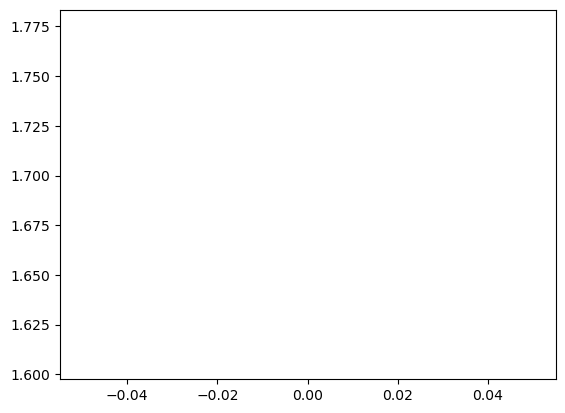

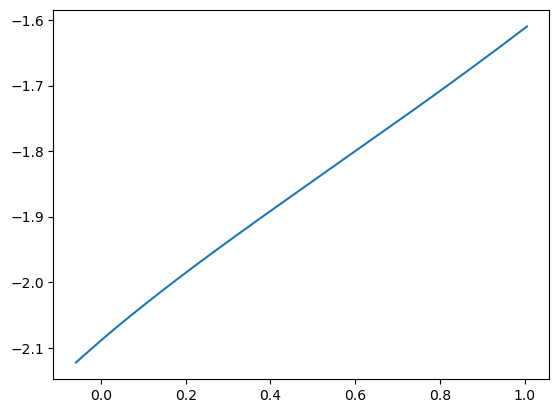

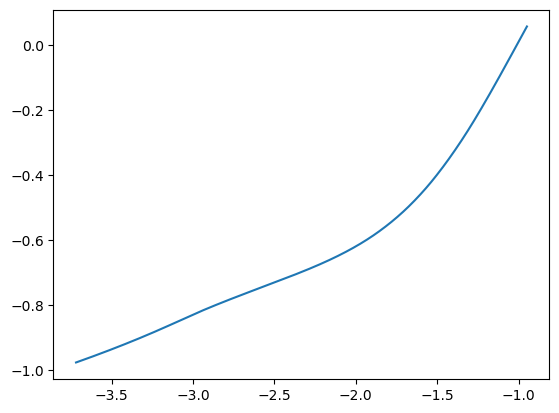

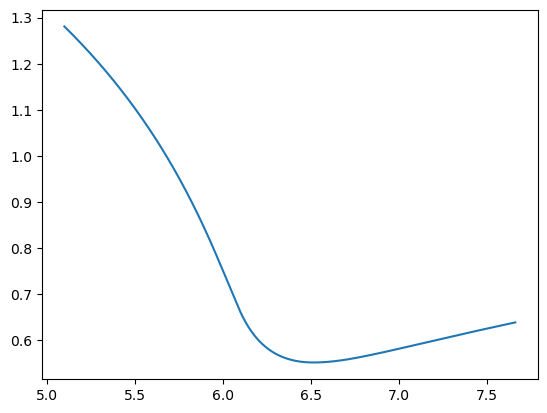

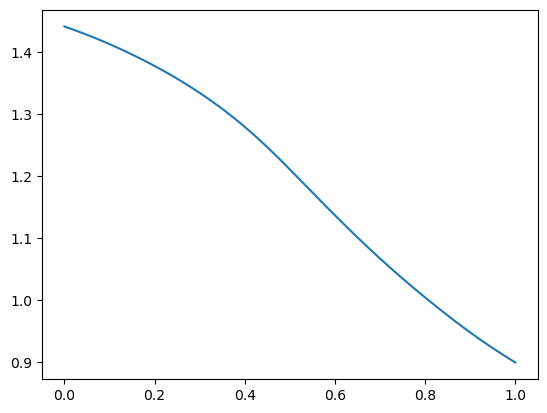

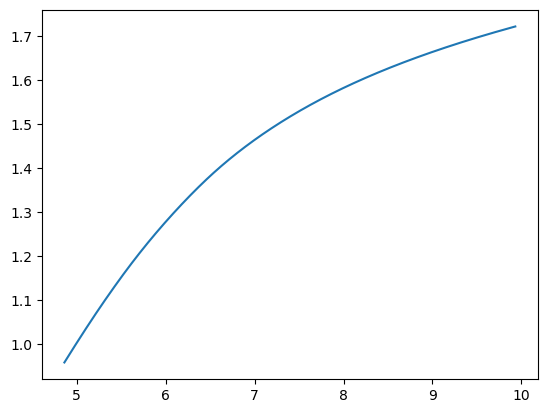

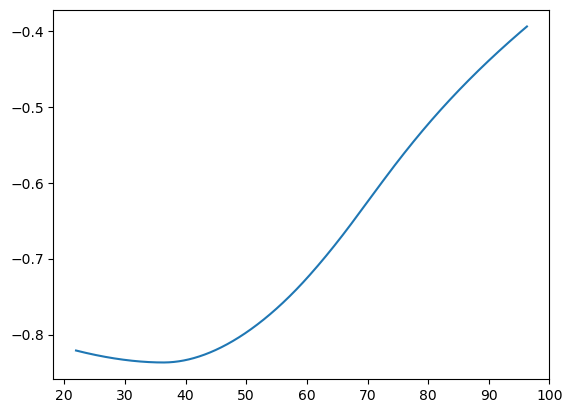

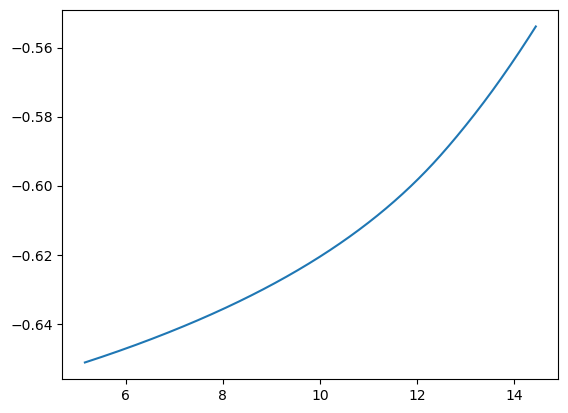

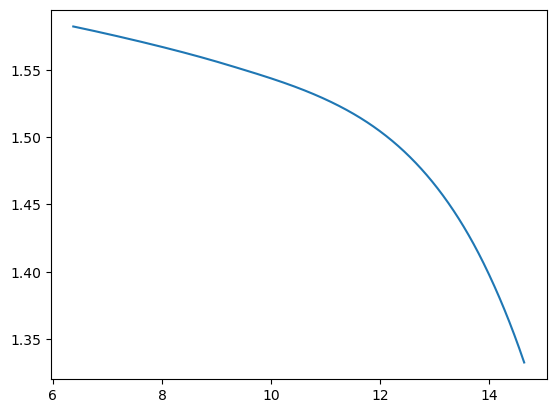

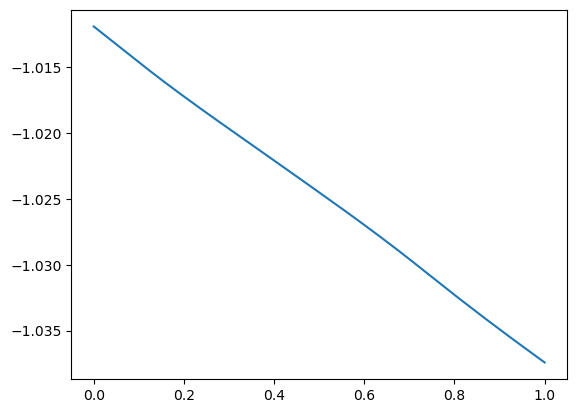

In [10]:
model._program.plot_shape_functions(dataset.numerical_ranges(X)|{i: (0,1) for i in dataset.categorical_dict},{})

In [11]:
from sklearn.base import BaseEstimator, RegressorMixin
from pycox.models.cox import _CoxPHBase
import torchtuples as tt


class SymRegPH(BaseEstimator, RegressorMixin, _CoxPHBase):
    """
    Wrapper for gplearn's SymbolicRegressor to use with pycox supporting functions
    """

    def __init__(self, model):
        self.model = model

    def fit(self, X, y, sample_weight, *args, **kwargs):
        self.model.fit(X, y, sample_weight=sample_weight)
        return self

    def predict(self, X, *args, **kwargs):
        if isinstance(X, tt.TupleTree):
            X = X[0]
        return self.model.predict(X)

    def silent(self):
        return self.model.set_params(verbose=False)

model_wrapped = SymRegPH(model)


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

C-index: 0.3591015818535619
pycox PLL: 6.772125244140625
torchsurv NPLL: 7.3882880210876465
IBS: 0.16699629798911025


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/paperspace/SurvSHAREs/survshares/plot.py:42: RuntimeWarning: divide by zero encountered in log
  return np.log(-np.log(1 - p))
/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/lifelines/fitters/mixins.py:20: RuntimeWarning: invalid value encountered in subtract
  return self.relu(x - knot) ** 3 - (lambda_ * self.relu(x - min_knot) ** 3 + (1 - lambda_) * self.relu(x - max_knot) ** 3)


ICI =  0.10028583138762266
E50 =  0.06269016093804985


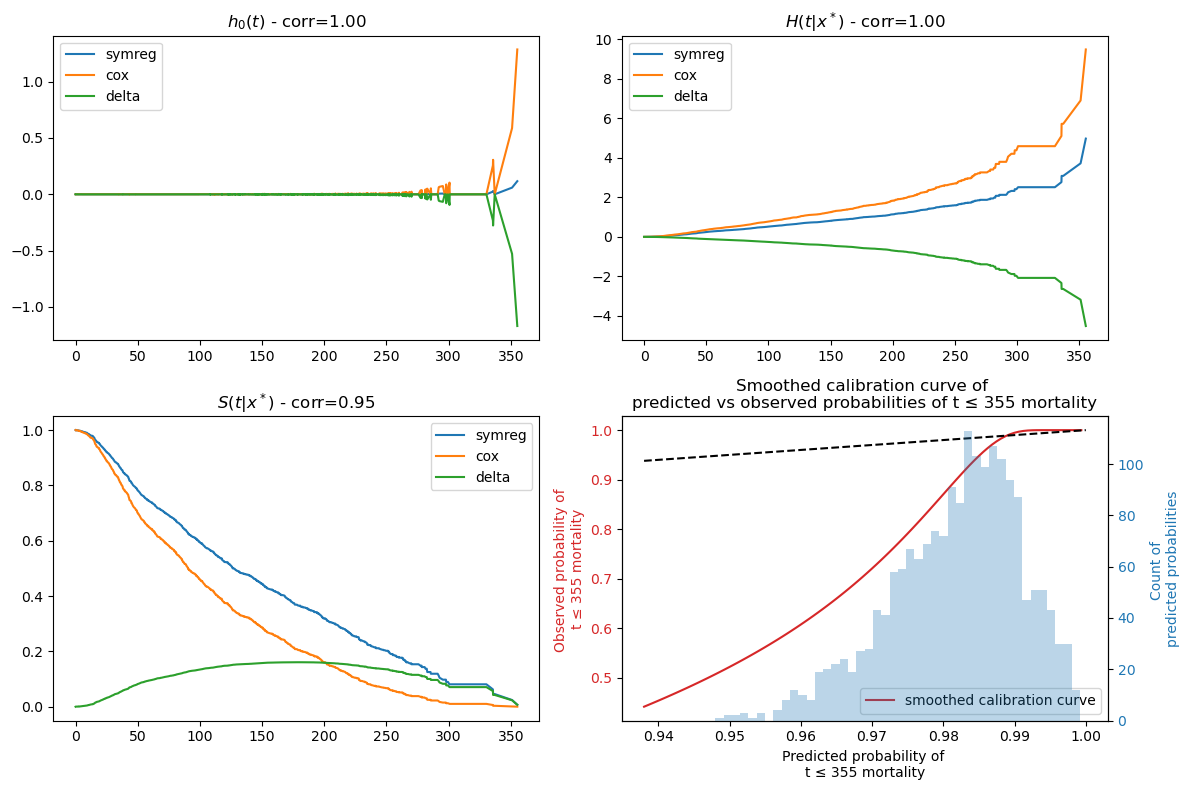

In [12]:
from lifelines import CoxPHFitter
from survshares.metrics import (
    c_index, 
    partial_likelihood,
    integrated_brier,
    negative_pll
)
import matplotlib.pyplot as plt 
from survshares.plot import survival_probability_calibration

class EvalSymRegPH:
    def __init__(self, model):
        self.model = model

    def score(self, X, T, E, sign=1):
        y_pred = sign * self.model.predict(X)
        h0_pred = self.model.compute_baseline_hazards(X, (T, E))
        surv_pred = self.model.predict_surv_df(X)
        print(f"C-index: {c_index(T, y_pred, E)}")
        print(f"pycox PLL: {partial_likelihood(T, y_pred, E)}")
        print(f"torchsurv NPLL: {negative_pll(T, y_pred, E)}")
        print(f"IBS: {integrated_brier(surv_pred, E, T)}")

    def plot_estimands(self, X, T, E, h0_scale_factor=1):
        X_df = pd.DataFrame(X).assign(time=T, event=E)
        cph = CoxPHFitter()
        cph.fit(X_df, duration_col="time", event_col="event")

        # This must run & store results in the symreg_cidx object before predict_cumulative_hazards can run
        h0_pred = self.model.compute_baseline_hazards(X, (T, E))
        h0_pred_scaled = h0_pred * h0_scale_factor
        h0_true = cph.baseline_hazard_["baseline hazard"]
        h0_corr = h0_pred.corr(h0_true, method="pearson")

        H0_pred = self.model.compute_baseline_cumulative_hazards(
            baseline_hazards_=h0_pred_scaled
        )
        H0_true = cph.baseline_cumulative_hazard_["baseline cumulative hazard"]
        H0_corr = H0_pred.corr(H0_true, method="pearson")

        # Select a random row in X
        idx = np.random.randint(0, len(X) - 1)
        X_star = X[idx : idx + 1]

        H_pred = self.model.predict_cumulative_hazards(X_star, baseline_hazards_=h0_pred_scaled)[0]  # For a random row in X
        H_true = cph.predict_cumulative_hazard(X_star)[0]
        H_corr = H_pred.corr(H_true, method="pearson")

        S_pred = self.model.predict_surv(X_star, baseline_hazards_=h0_pred_scaled)[0]  # For a random row in X
        S_true = cph.predict_survival_function(X_star)[0]
        S_corr = pd.Series(S_pred).corr(S_true, method="pearson")

        surv_pred = self.model.predict_surv_df(X)

        fig, ax = plt.subplots(2, 2, figsize=(12, 8))
        ax = np.ravel(ax)

        h0_dict = dict(symreg=h0_pred, cox=h0_true, delta=h0_pred_scaled - h0_true)
        if h0_scale_factor != 1:
            h0_dict["symreg_scaled"] = h0_pred_scaled

        pd.DataFrame(h0_dict).plot(ax=ax[0], title=f"$h_0(t)$ - corr={h0_corr:.2f}")
        pd.DataFrame(dict(symreg=H_pred, cox=H_true, delta=H_pred - H_true)).plot(
            ax=ax[1], title=f"$H(t|x^*)$ - corr={H_corr:.2f}"
        )
        pd.DataFrame(dict(symreg=S_pred, cox=S_true, delta=S_pred - S_true)).plot(
            ax=ax[2], title=f"$S(t|x^*)$ - corr={S_corr:.2f}"
        )

        survival_probability_calibration(surv_pred, T+0.01, E, t0=(T+0.01).max(), ax=ax[3])

EvalSymRegPH(model_wrapped).score(X, T, E)
EvalSymRegPH(model_wrapped).plot_estimands(X,T,E)